In [82]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 9)

In [83]:
img1 = cv2.imread('data/guitarneck.jpg')
img2 = cv2.imread('data/guitar_.jpg')

In [84]:
orb = cv2.ORB_create()
kps1, des1 = orb.detectAndCompute(img1, None)
kps2, des2 = orb.detectAndCompute(img2, None)

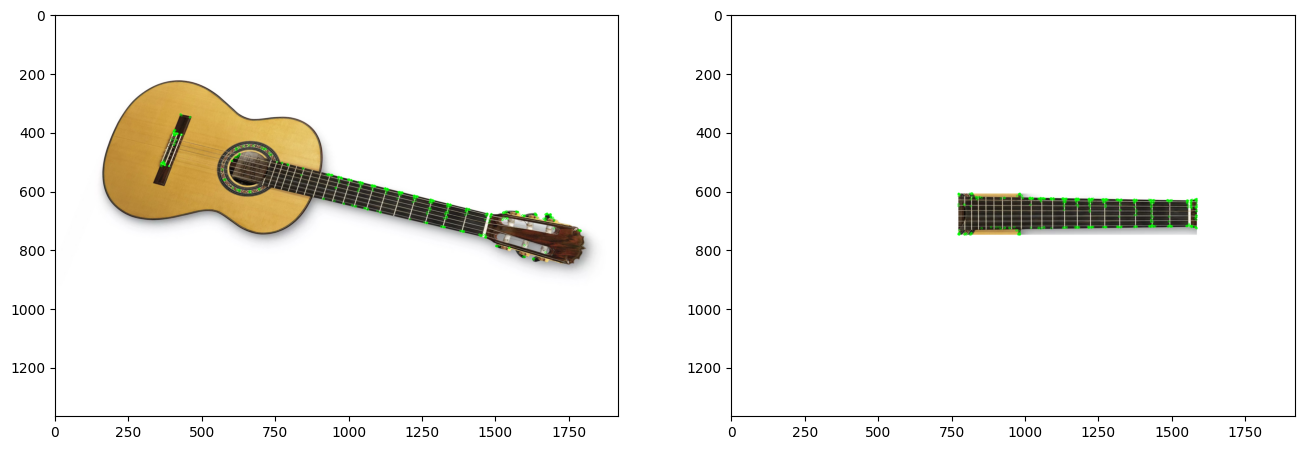

In [85]:
kp_img1 = cv2.drawKeypoints(img1, kps1, None, color=(0,255,0))
kp_img2 = cv2.drawKeypoints(img2, kps2, None, color=(0,255,0))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(kp_img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(kp_img2, cv2.COLOR_BGR2RGB))
plt.show()

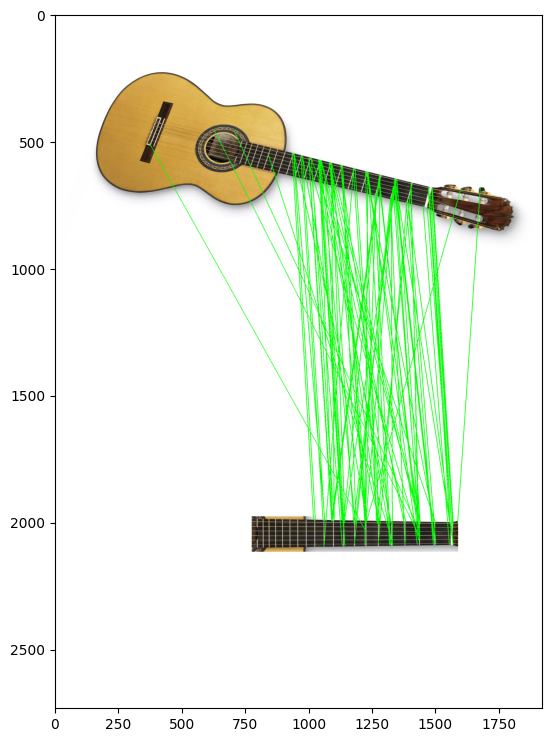

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming img1, kps1, des1, img2, kps2, des2 are your images, keypoints, and descriptors

# Create a Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors using the BFMatcher
matches = bf.match(des1, des2)

# Stack images vertically
stacked_img = cv2.vconcat([img1, img2])

# Draw the matched lines on the stacked image
lines = []
for match in matches[:100]:
    pt1 = (int(kps1[match.queryIdx].pt[0]), int(kps1[match.queryIdx].pt[1]))
    pt2 = (int(kps2[match.trainIdx].pt[0]), int(kps2[match.trainIdx].pt[1] + img1.shape[0]))  # Shift the y-coordinate for the second image
    lines.append([pt1[0], pt1[1], pt2[0], pt2[1]])

# Remove lines that cross a large number of other lines
filtered_lines = []
for i in range(len(lines)):
    crossing_count = 0
    for j in range(len(lines)):
        if i != j:
            x1, y1, x2, y2 = lines[i]
            x3, y3, x4, y4 = lines[j]
            # Check if line i crosses 70% of the other lines
            if (
        min(x1, x2) < max(x3, x4) and
        min(y1, y2) < max(y3, y4) and
        min(x3, x4) < max(x1, x2) and
        min(y3, y4) < max(y1, y2) and
        ((x1 - x2) * (y3 - y1) - (y1 - y2) * (x3 - x1)) * ((x1 - x2) * (y4 - y1) - (y1 - y2) * (x4 - x1)) < 0
    ):
                crossing_count += 1

    if crossing_count < 0.7 * len(lines):
        filtered_lines.append(lines[i])

# Draw the filtered lines on the stacked image
for line in filtered_lines:
    pt1 = (int(line[0]), int(line[1]))
    pt2 = (int(line[2]), int(line[3]))
    cv2.line(stacked_img, pt1, pt2, (0, 255, 0), 2)

# Display the stacked image with matches using matplotlib
plt.imshow(cv2.cvtColor(stacked_img, cv2.COLOR_BGR2RGB))
plt.show()


In [97]:
src_pts = np.array([kps1[match.queryIdx].pt for match in matches])
dst_pts = np.array([kps2[match.trainIdx].pt for match in matches])

M, mask = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC)

matchesMask = mask.ravel().tolist()
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

ValueError: too many values to unpack (expected 2)

In [ ]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kps1,img2,kps2,matches,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

In [87]:
def get_homography(pts1, pts2):
    """Estimate the affine transformation between two lists of matching
    keypoint coordinates.
    
    Args:
    - pts1: List of (x, y) coordinates.
    - pts2: List of (x, y) coordinates.
    
    Returns:
    - t: 3x3 array representing the projective transformation matrix that
          maps `pts1` to `pts2`.
    """
    assert len(pts1) == len(pts2), \
        "`pts1` and `pts2` must have equal length."
    # Construct the A matrix
    A = []
    for i in range(len(pts1)):
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]
        A.append([-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2])
        A.append([0, 0, 0, -x1, -y1, -1, x1*y2, y1*y2, y2])
    
    A = np.array(A)
    
    # Solve for h using SVD
    _, _, Vt = np.linalg.svd(A)
    t = Vt[-1].reshape(3, 3)
    
    return t


# Test the function on sample keypoints.
pts1 = [
    [313.9, 316.8],
    [120.0, 284.0],
    [437.2, 501.1],
    [221.0, 510.0],
]
pts2 = [
    [318.0, 372.0],
    [151.0, 390.0],
    [466.6, 504.0],
    [304.0, 571.0],
]

t = get_homography(pts1, pts2)

print(t)

[[ 5.62558185e-03  1.98911992e-03 -2.67262500e-01]
 [-1.11606724e-03  5.92492523e-03  9.63565713e-01]
 [ 1.32247912e-06 -1.23451088e-07  6.31819957e-03]]


In [88]:
import random

def estimate_transformation_ransac(kps1, kps2, matches, transform_func,
    n_samples, n_trials, inlier_thresh):
    best_transform = None
    best_inlier_mask = None
    max_inliers = 0

    for _ in range(n_trials):
        # Randomly sample n_samples matches
        sampled_matches = np.random.choice(matches, n_samples, replace=False)

        # Get the keypoints corresponding to the sampled matches
        src_pts = np.array([kps1[match.queryIdx].pt for match in sampled_matches])
        dst_pts = np.array([kps2[match.trainIdx].pt for match in sampled_matches])

        # Estimate the transformation using the provided transform_func
        transform = transform_func(src_pts, dst_pts)

        # Calculate the transformed points
        homogeneous_points = np.hstack((np.array([kp.pt for kp in kps1], dtype=np.float32), np.ones((len(kps1), 1))))
        transformed_pts = np.dot(transform, homogeneous_points.T).T

        # Convert the result back to 2D coordinates by dividing by the third coordinate (w)
        transformed_pts = transformed_pts[:, :2] / transformed_pts[:, 2, None]

        # Calculate the Euclidean distance between the transformed keypoints and kps2
        errors = np.linalg.norm(transformed_pts - np.array([kp.pt for kp in kps2], dtype=np.float32), axis=1)

        # Identify inliers based on the threshold
        inlier_mask = errors < inlier_thresh
        n_inliers = np.sum(inlier_mask)

        if n_inliers > max_inliers:
            max_inliers = n_inliers
            best_transform = transform
            best_inlier_mask = inlier_mask

    return best_transform, best_inlier_mask

transform, mask = estimate_transformation_ransac(kps1, kps2, matches,
    get_homography, 4, 1000, 2)

print(f"The transformation matrix:\n{transform}.")
print(f"{np.sum(mask)} out of {len(matches)} matches are inliers.")

The transformation matrix:
[[-3.42736455e-04  2.15492853e-03 -9.25681063e-01]
 [-1.40053622e-04  8.80625295e-04 -3.78297049e-01]
 [-2.20732544e-07  1.38789684e-06 -5.96205733e-04]].
6 out of 135 matches are inliers.


The following cell warps image 1 based on the estimated homography and displays the overlay of the aligned images.

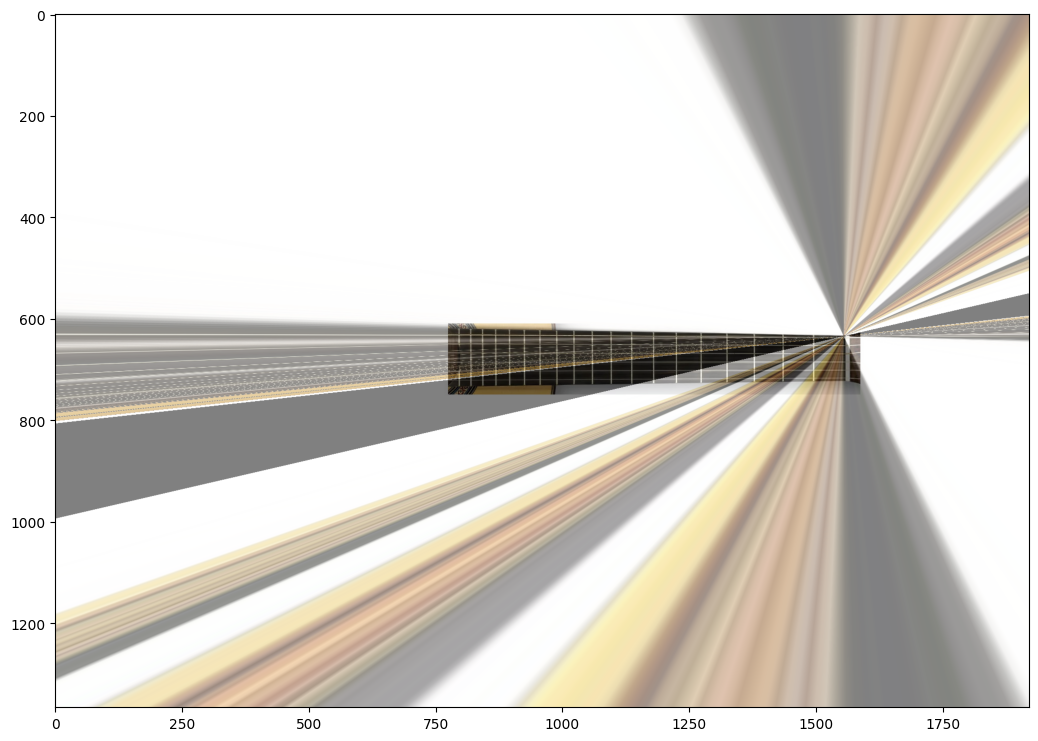

In [94]:
def stitch_images(img1, img2, transform):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp corners of image 1 to coordinates system of image 2.
    corners = np.array([
        [0., w1, w1, 0.],
        [0., 0., h1, h1],
        [1., 1., 1., 1.]
    ])
    new_corners = transform @ corners
    new_corners /= new_corners[2, :]
    # Calculate range of warped image 1.
    l = np.min(new_corners[0, :])
    r = np.max(new_corners[0, :])
    t = np.min(new_corners[1, :])
    b = np.max(new_corners[1, :])
    # Calculate size of the stitched image.
    l = np.min((l,  0))
    r = np.max((r, w2))
    t = np.min((t,  0))
    b = np.max((b, h2))
    w = int(np.round(r-l))
    h = int(np.round(b-t))
    # Calculate how much we should shift the stitched image.
    dx = max((-l, 0.))
    dy = max((-h, 0.))
    shift = np.array([
        [1., 0., dx],
        [0., 1., dy],
        [0., 0., 1.]
    ])

    # Warp input images and overlay them.
    warped_img1 = cv2.warpPerspective(img1, shift @ transform, (w, h))
    warped_img2 = cv2.warpPerspective(img2, shift, (w, h))
    overlayed_img = cv2.addWeighted(warped_img1, 0.5, warped_img2, 0.5, 0.0)
    return overlayed_img


stitched_img = stitch_images(img1, img2, transform)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.show()